In [1]:
import sveCacheSim as sim
import CacheModels
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm
import importlib
importlib.reload(sim)
import os
import PhaseDetector
importlib.reload(PhaseDetector)
pass

import ruptures as rpt

In [2]:
# Paths
os.chdir('/storage/home/hhive1/plavin3/data/ModelSwapping')
DATADIR = '/storage/home/hhive1/plavin3/scratch/DataV5/'

In [3]:
# Traces
small_trace  = 'traces/memtrace.meabo.i125.N512.P521.L1.log'
medium_trace = 'traces/memtrace.meabo.i125.N512.P521.L2.log'
large_trace  = 'traces/memtrace.meabo.i125.N1536.P521.L3.log'

new_trace    = '/storage/hive/project/coc-young/plavin3/tracing/meabo/memtrace.meabo.x86_64.347405.0000.log'

# Choose one
select_trace = new_trace

In [4]:
# Run PD
trace = sim.traceToInts(select_trace, None)
phd   = PhaseDetector.PhaseDetector(stable_min=5, interval_len=1e5)
for ip in tqdm(trace.IP):
    phd.access(ip)
stats = phd.finalize()

100%|██████████| 38000997/38000997 [07:14<00:00, 87557.50it/s]


In [5]:
sim.save_object(stats, 'stats_new.backup.pkl')

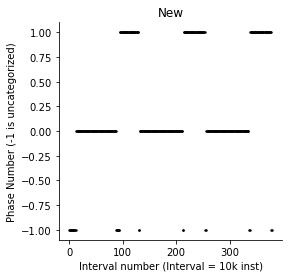

In [7]:
def plot_trace(ax, label, trace, axis_labels):
    ax.scatter([*range(len(trace))], trace,s=2, color='black')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(label)
    if axis_labels:
        ax.set_ylabel('Phase Number (-1 is uncategorized)')
        ax.set_xlabel('Interval number (Interval = 10k inst)')

fig, ax = plt.subplots(1, 1, figsize=(4,4))
plot_trace(ax, 'New',  stats.trace,  True)
#plot_trace(ax[1], 'Medium', trace_medium, False)
#plot_trace(ax[2], 'Large',  trace_large,  False)
#plt.savefig('plots/phase-traces.svg')
plt.show()

In [14]:
score_signal = np.zeros(len(stats.sig_trace)-1)

for i in tqdm(range(len(stats.sig_trace)-1)):
    score_signal[i] = PhaseDetector._similarity(stats.sig_trace[i+1], stats.sig_trace[i])

    
breakpoints = []

for i,_ in enumerate(stats.trace):
    if i == 0:
        continue
        
    if stats.trace[i] != stats.trace[i-1]:
        breakpoints.append(i)
        
print(breakpoints)

100%|██████████| 379/379 [00:00<00:00, 529.79it/s]

[13, 88, 95, 130, 132, 212, 214, 254, 256, 336, 338, 378]


In [41]:
#simi = np.empty([len(stats.sig_trace), len(stats.sig_trace)])
#for i in tqdm(range(len(stats.sig_trace))):
#    for j in range(i, len(stats.sig_trace)):
#        simi[i][j] = PhaseDetector._similarity(stats.sig_trace[i], stats.sig_trace[j])

100%|██████████| 93/93 [00:16<00:00,  5.65it/s]


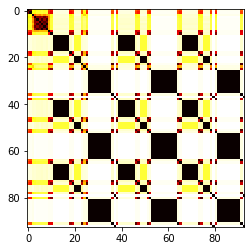

In [45]:
#plt.imshow(simi, cmap='hot', interpolation='nearest')
#plt.show()

[55, 115, 175, 235, 300]


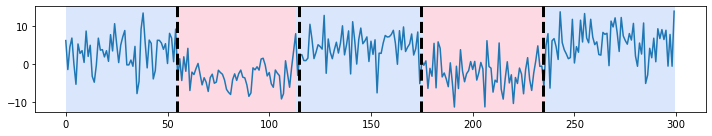

In [17]:
# generate signal
n_samples, dim, sigma = 300, 1, 4
n_bkps = 4  # number of breakpoints
signal, bkps = rpt.pw_constant(n_samples, dim, n_bkps, noise_std=sigma)

# detection
algo = rpt.Pelt(model="rbf").fit(signal)
result = algo.predict(pen=10)

print(result)

# display
rpt.display(signal, bkps, result)
plt.show()

[379]


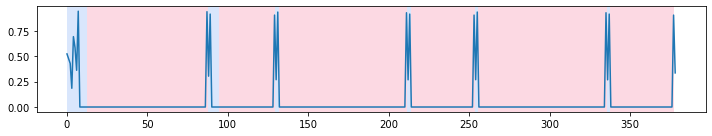

In [16]:
# detection
algo = rpt.Pelt(model="rbf").fit(score_signal)
result = algo.predict(pen=10)

print(result)

# display
rpt.display(score_signal, breakpoints, result)
plt.show()

In [30]:
# That didn't work because the transitions are treated as anomalies, and ignored
# Let's reinterpret the signatures as ints

val2 = stats.sig_trace[0].intValue()
val1 = stats.sig_trace[1].intValue()
sig2int = [s.intValue() for s in stats.sig_trace]
maxsigval = max(sig2int)
normint = np.array([s/maxsigval for s in sig2int])


[90, 130, 215, 255, 335, 380]


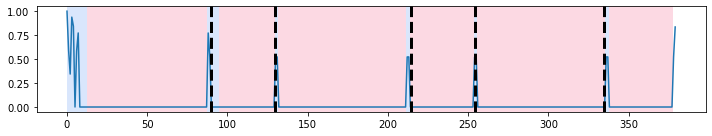

In [29]:
# detection
algo = rpt.Pelt(model="rbf").fit(normint)
result = algo.predict(pen=10)

# display
rpt.display(normint, breakpoints, result)
plt.show()